In [1]:
import numpy as np
import gridData as gd
#see https://www.mdanalysis.org/GridDataFormats/gridData/core.html#gridData.core.Grid
import matplotlib.pyplot as plt
import os
import sys

processing 856 frames for aac1 run 1
max along z: 26.294369647217017
std instantaneous maximum electrostatic potential along wires: 8.111098784034107 kT/e at 300K
average instantaneous maximum electrostatic potential along wires: 34.493899762589976 kT/e at 300K
skipping aac1 run 2
skipping aac1 run 3
skipping aac1 run 4
skipping aac1 run 5
processing 645 frames for aac1 run 6
max along z: 19.243332545852198
std instantaneous maximum electrostatic potential along wires: 7.5685829275489365 kT/e at 300K
average instantaneous maximum electrostatic potential along wires: 31.338926344923348 kT/e at 300K


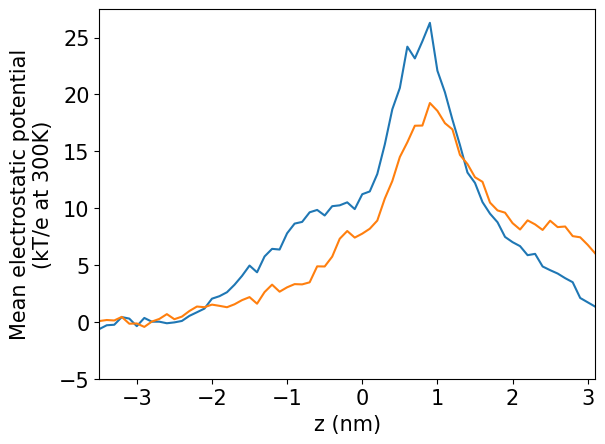

skipping ucp1 run 1
skipping ucp1 run 2
skipping ucp1 run 3
processing 144 frames for ucp1 run 4
max along z: 13.940245480234367
std instantaneous maximum electrostatic potential along wires: 7.804970113132032 kT/e at 300K
average instantaneous maximum electrostatic potential along wires: 29.18155359319733 kT/e at 300K
skipping ucp1 run 5
skipping ucp1 run 6


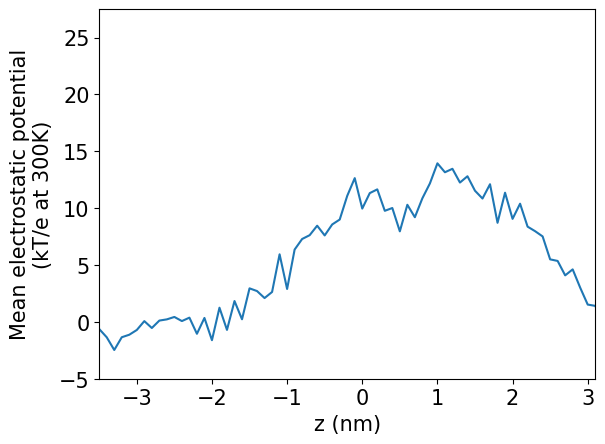

In [6]:
#load matching dx and npy files and look at the potential values from the dx files at the coordinates in the npy files

#path to .dx files with electrostatic potential grids
dxpath = "/home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/electric_potential/"
#path to .npy files with water wire atom coordinates
xyzpath = "/home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/water_wires_2"

proteins = ["aac1", "ucp1"]
servers = ["wynton", "degrabo"]

plot_vz = True

#constants for rate calculations
rate_base = 1196.89 #s^-1 #really this has about 1-2 significant figures
membrane_potential = -160 #meV
kT = 25.7 #meV at T=298 K
h = 1/2 #membrane potential fraction at the transition state, assuming linear combination of membrane and protein potential

for protein in proteins:
    ri = 0
    for server in servers:
        for run in range(1,5):
            if server == "degrabo" and run > 2:
                continue
            ri += 1

            #------------------------------------------------------------------------------------------------
            #load electrostatic potentials
            _dxpath = dxpath+protein+f"_run{ri}/"
            if not os.path.exists(_dxpath):
                print(f"skipping {protein} run {ri}")
                continue

            dxfiles = [f for f in os.listdir(_dxpath) if f[0:9] == "potential"]
            #put files in order
            dxfiles_sorted = sorted(dxfiles, key=lambda x: int(x.split("-")[3].split(".")[0]))

            #------------------------------------------------------------------------------------------------
            #load water wire coordinates
            runstr = f"run{str(run).zfill(2)}"
            xyzpath_local = "/".join([xyzpath, server, protein, runstr])
            xyzfiles = os.listdir(xyzpath_local)

            xyzpaths = []
            for seg in range(20):

                segstr = f"seg{str(seg).zfill(2)}"
                fnq = f"{protein}-{server}-{runstr}-{segstr}"

                #find all the xyz files for water wires in the current segment in order and then take every 10th one to match what the frame extraction script which was fed into VMD did
                xyzpaths += [f"{xyzpath_local}/{fnq}-frameind{frame}-xyz.npy" for frame in range(15000) if os.path.exists(f"{xyzpath_local}/{fnq}-frameind{frame}-xyz.npy")][::10]

            #------------------------------------------------------------------------------------------------
            #combine to get potentials along water wire

            if len(xyzpaths) > 0 and len(xyzpaths) == len(dxfiles_sorted):
                print(f"processing {len(xyzpaths)} frames for {protein} run {ri}")

                #determine bulk potentials
                c_bulk = []
                m_bulk = []

                #determine potential as a function of z
                bins = np.arange(-4,4,0.1)
                potentials_by_bin = [[] for i in range(len(bins)+1)]

                #maximum potentials along each wire and the z coordinates thereof
                max_potentials = []
                zmax = []

                #loop over frames
                for fxyz, fdx in zip(xyzpaths, dxfiles_sorted):
                    
                    #load the wire and potential grid for the current frame
                    g1 = gd.Grid(_dxpath + fdx)
                    xyz = np.load(fxyz)

                    #potential in solvent
                    c_bulk.append(np.mean(g1.grid[:,:,8]))
                    m_bulk.append(np.mean(g1.grid[:,:,80]))

                    #electric potentials along the wire
                    wire_potentials = [g1.grid[int(round(c[0]*(96/9.2)+48)), int(round(c[1]*(96/9.2)+48)), int(round(c[2]*(96/9.2)+44))] for c in xyz]

                    max_potentials.append(np.max(wire_potentials))
                    zmax.append(xyz[np.argmax(wire_potentials)][2])

                    #bin potentials along z and add to list
                    wat_bins = np.digitize(xyz[:,2], bins)
                    for b, p, in zip(wat_bins, wire_potentials):
                        potentials_by_bin[b].append(p)

                #average solution potential
                bulk_avg = (np.mean(c_bulk)+np.mean(m_bulk))/2


                #------------------------------------------------------------------------------------------------
                #plotting
            
                if plot_vz:
                    #plot electric potential along z relative to bulk

                    plt.rcParams.update({'font.size': 15})
                    # creating a dictionary
                    font = {'size': 15}
                    # using rc function
                    plt.rc('font', **font)

                    print(f"max along z: {max([np.mean(b)-bulk_avg for b in potentials_by_bin if len(b) > 0])}")

                    plt.plot(list(bins) + [4], [np.mean(b)-bulk_avg for b in potentials_by_bin])
                    plt.xlabel("z (nm)")
                    plt.ylabel("Mean electrostatic potential\n(kT/e at 300K)")

                    end1 = bins[np.argsort([len(b) for b in potentials_by_bin])[-1]]
                    end2 = bins[0:int(len(bins)/2)][np.argsort([len(b) for b in potentials_by_bin[0:int(len(bins)/2)]])[-1]]
                    # print(end1, end2)
                    plt.xlim(end2, end1)
                    plt.ylim(-5, 27.5)
                
                # else:
                #     #plot distribution of max potentials and max potential coordinates along water wires

                #     max_potentials_b = [m-bulk_avg for m in max_potentials]
                #     plt.hist(max_potentials_b, bins = 20, density=True)
                #     plt.xlabel("Maximum electrostatic potential (kT/e at 300K)")
                #     plt.ylabel("probability")
                #     plt.title(f"{protein.upper()} run {ri} maximum potentials")

                #     plt.savefig(f"{dxpath}/{protein}-VMD-pmepot-max-potential-distribution-{ri}.svg", format="svg", bbox_inches="tight")
                #     plt.show()

                #     plt.hist(zmax, bins = 20, density = True)
                #     plt.xlabel("z coordinate of the point of maximum potential\n(nm)")
                #     plt.ylabel("probability")
                #     plt.title(f"{protein.upper()} run {ri} maximum potential locations")

                #     plt.savefig(f"{dxpath}/{protein}-VMD-pmepot-max-potential-z-distribution-{ri}.svg", format="svg", bbox_inches="tight")
                #     plt.show()

                print(f"std instantaneous maximum electrostatic potential along wires: {np.std(max_potentials)} kT/e at 300K")
                print(f"average instantaneous maximum electrostatic potential along wires: {np.mean(max_potentials)-bulk_avg} kT/e at 300K")
            
            else:
                print(f"{protein} run {ri} had {len(xyzpaths)} wire coordinates and {len(dxfiles_sorted)} potential grids")

    if plot_vz:
        plt.savefig(f"{dxpath}/{protein}-VMD-pmepot-potential.svg", format="svg", bbox_inches="tight")
        plt.show()




In [17]:
kB = 1.380649*(10**-23) #J/K
T = 300 #K
eV = 1.602*(10**-19) #J

print(eV/(kB*T)*13.94)



539.1638280258052


In [ ]:
#######################################################################################################################
#                                                    OLD CODE BELOW
#######################################################################################################################

856
0


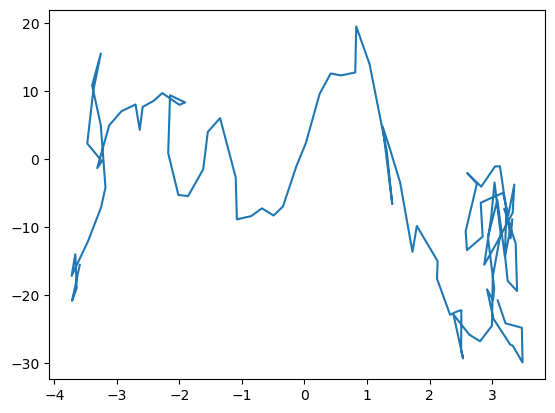

100


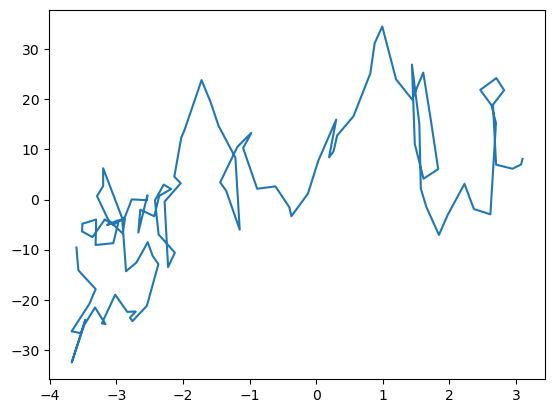

200


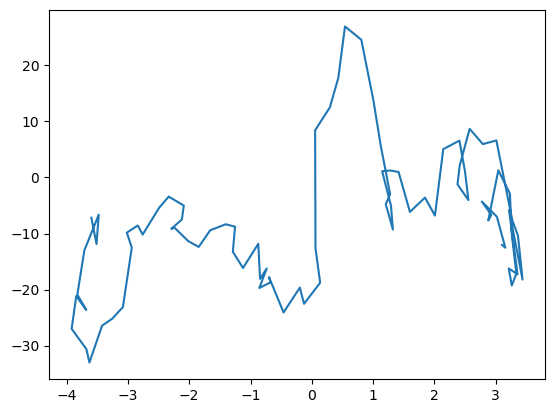

300


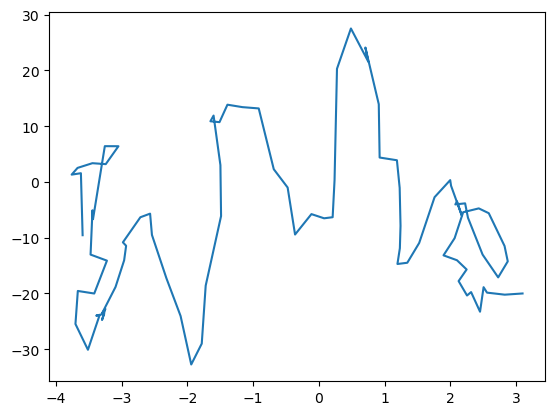

400


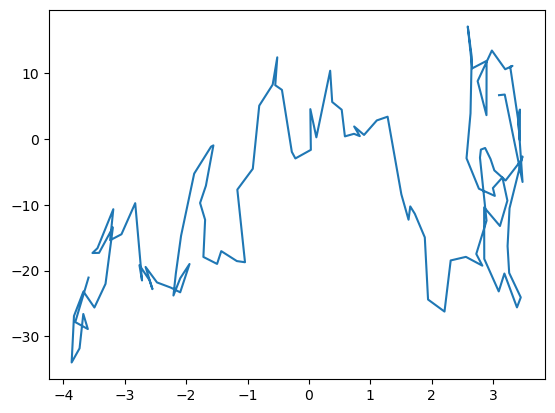

500


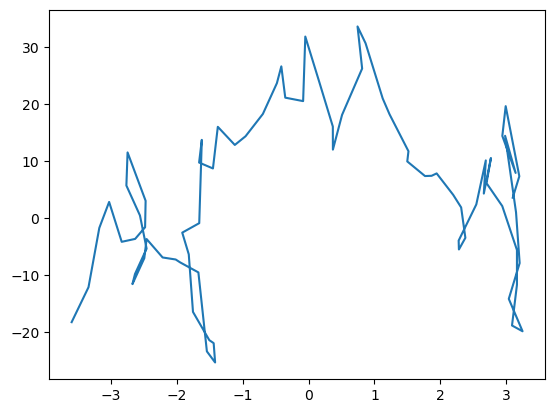

600


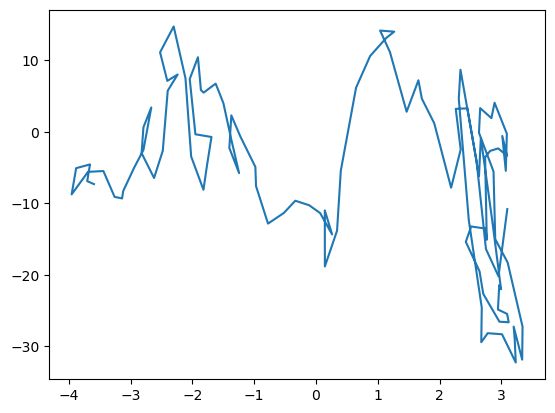

700


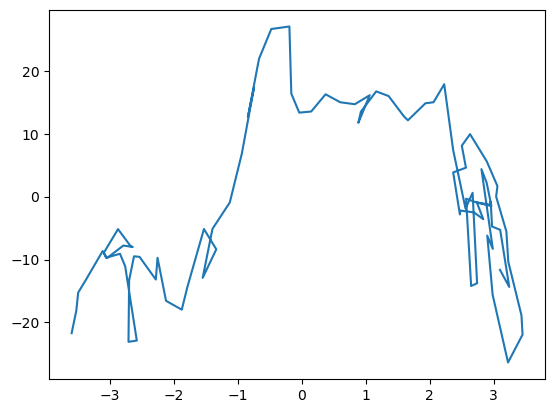

800


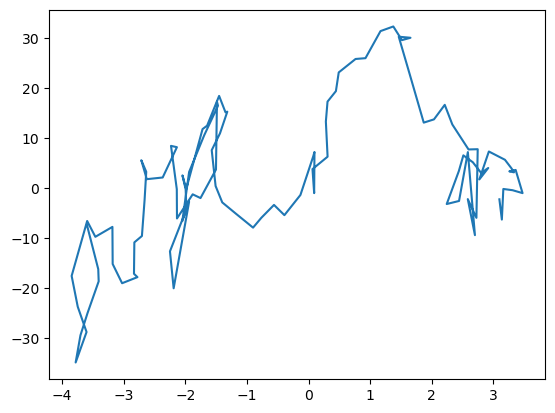

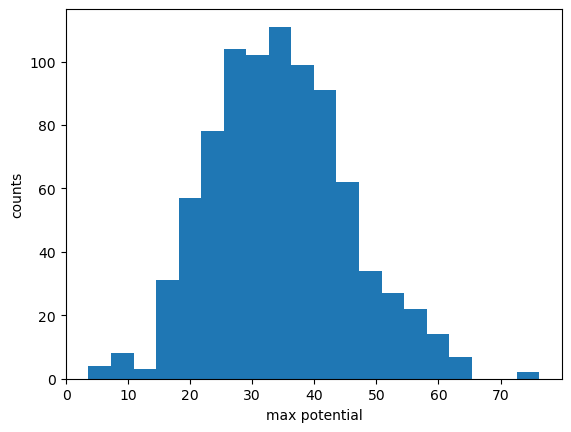

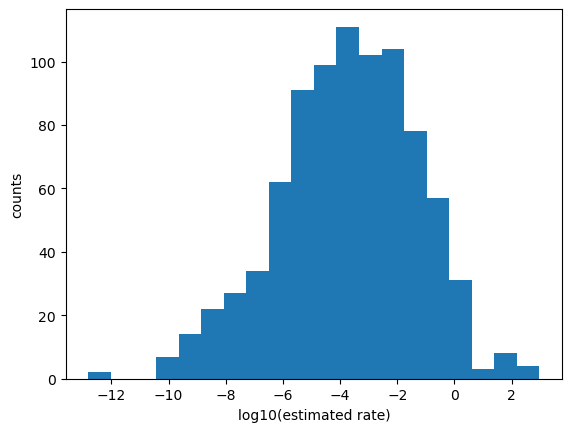

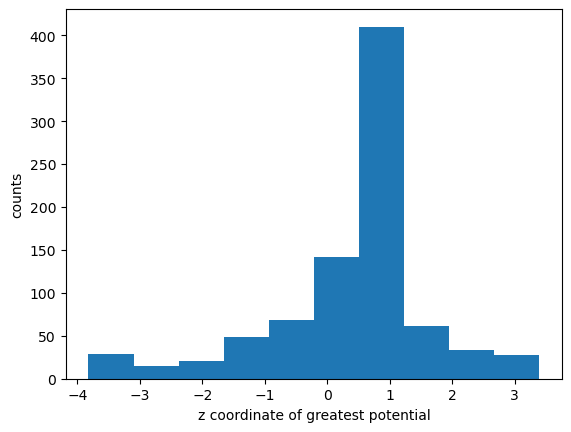

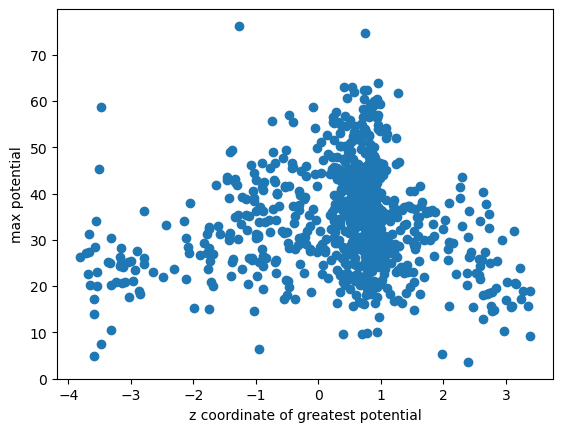

/home/jonathan/anaconda3/envs/serpents/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jonathan/anaconda3/envs/serpents/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


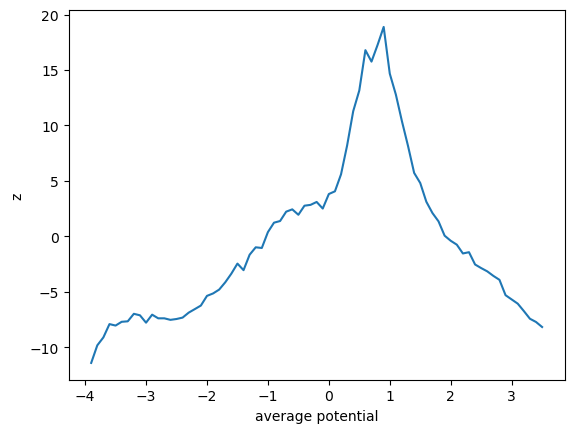

-----------------------------------
3.0014145725676973
936.2214481426292
34.51821808175234
11.101965481716157
76.25014999999999
13
35
0
1
645


In [ ]:
#load matching dx and npy files and look at the potential values from the dx files at the coordinates in the npy files

#path to .dx files with electrostatic potential grids
dxpath = "/home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/electric_potential/"
#path to .npy files with water wire atom coordinates
xyzpath = "/home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/water_wires_2"

proteins = ["aac1", "ucp1"]
servers = ["wynton", "degrabo"]

#constants for rate calculations
rate_base = 1196.89 #s^-1 #really this has about 1-2 significant figures
membrane_potential = -160 #meV
kT = 25.7 #meV at T=298 K
h = 1/2 #membrane potential fraction at the transition state, assuming linear combination of membrane and protein potential

for protein in proteins:
    for server in servers:
        for run in range(1,5):
            if server == "degrabo" and run > 2:
                continue

            #------------------------------------------------------------------------------------------------
            #load electrostatic potentials
            dxfiles = [f for f in os.listdir(dxpath) if f[0:9] == "potential"]
            #put files in order
            dxfiles_sorted = sorted(dxfiles, key=lambda x: int(x.split("-")[3].split(".")[0]))

            #------------------------------------------------------------------------------------------------
            #load water wire coordinates
            runstr = f"run{str(run).zfill(2)}"
            xyzpath_local = "/".join([xyzpath, server, protein, runstr])
            xyzfiles = os.listdir(xyzpath_local)

            xyzpaths = []
            for seg in range(20):

                segstr = f"seg{str(seg).zfill(2)}"
                fnq = f"{protein}-{server}-{runstr}-{segstr}"

                #find all the xyz files for water wires in the current segment in order and then take every 10th one to match what the frame extraction script which was fed into VMD did
                xyzpaths += [f"{xyzpath_local}/{fnq}-frameind{frame}-xyz.npy" for frame in range(15000) if os.path.exists(f"{xyzpath_local}/{fnq}-frameind{frame}-xyz.npy")][::10]



            #combine to get potentials along wire
            print(len(xyzpaths))
            if len(xyzpaths) > 0 and len(xyzpaths) == len(dxfiles_sorted):

                bins = np.arange(-4,4,0.1)
                potentials_by_bin = [[] for i in range(len(bins)+1)]

                c_bulk = []
                m_bulk = []

                max_potentials = []
                rates = []
                zmax = []
                xx = 0
                for fxyz, fdx in zip(xyzpaths, dxfiles_sorted):
                    #print(dxpath + fdx)
                    g1 = gd.Grid(dxpath + fdx)
                    xyz = np.load(fxyz)

                    # print(xyz[0][2])
                    # print(xyz[-1][2])
                    # sys.exit(0)

                    wire_potentials = [g1.grid[int(round(c[0]*(96/9.2)+48)), int(round(c[1]*(96/9.2)+48)), int(round(c[2]*(96/9.2)+44))] for c in xyz] # if c[2] < 2 and c[2] > -2

                    max_potentials.append(np.max(wire_potentials)-(wire_potentials[0]+wire_potentials[-1])/2)
                    rates.append(rate_base*np.exp(-(max_potentials[-1] + h*membrane_potential/kT)/2)) # conveniently the vmd potentials are in kT/e
                    zmax.append(xyz[np.argmax(wire_potentials)][2])

                    wat_bins = np.digitize(xyz[:,2], bins)

                    c_bulk.append(np.mean(g1.grid[:,:,8]))
                    m_bulk.append(np.mean(g1.grid[:,:,80]))

                    if len(wat_bins) != len(wire_potentials):
                        print("error")
                        print(len(wat_bins))
                        print(len(wire_potentials))
                        break
                    for b, p, in zip(wat_bins, wire_potentials):
                        potentials_by_bin[b].append(p)

                    vs = 40

                    plot_by_slice = False
                    if plot_by_slice:
                        for i in range(0,88,10):
                            plt.imshow(g1.grid[:, :, i].transpose(), vmax = vs, vmin = -vs)
                            plt.title(f'z slice at index {i}')
                            plt.colorbar(label='Electric Potential (kT/e)')

                            for c in xyz:
                                if c[2]*(96/9.2)+44 >= i-5 and c[2]*(96/9.2)+44 < i+5:
                                    plt.scatter([c[0]*(96/9.2)+48], [c[1]*(96/9.2)+48], color = "red") 

                        plt.show()


                    if xx % 100 == 0:
                        print(xx)
                        plt.plot(xyz[:,2], wire_potentials)
                        plt.show()

                    xx += 1


                plt.hist(max_potentials, bins = 20)
                plt.xlabel("max potential")
                plt.ylabel("counts")
                plt.show()

                plt.hist([np.log10(r) for r in rates], bins = 20)
                plt.xlabel("log10(estimated rate)")
                plt.ylabel("counts")
                plt.show()

                plt.hist(zmax)
                plt.xlabel("z coordinate of greatest potential")
                plt.ylabel("counts")
                plt.show()

                plt.scatter(zmax, max_potentials)
                plt.xlabel("z coordinate of greatest potential")
                plt.ylabel("max potential")
                plt.show()

                plt.plot(list(bins) + [4], [np.mean(b) for b in potentials_by_bin])
                plt.xlabel("average potential")
                plt.ylabel("z")
                plt.show()
                
                print("-----------------------------------")
                print(np.mean(rates))
                print(np.max(rates))

                print(np.mean(max_potentials))
                print(np.std(max_potentials))
                print(np.max(max_potentials))




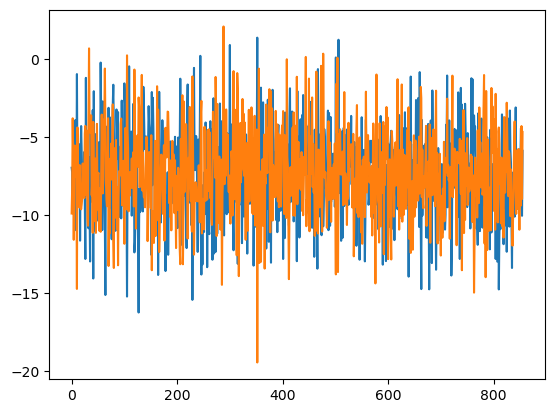

In [19]:
plt.plot(c_bulk)
plt.plot(m_bulk)

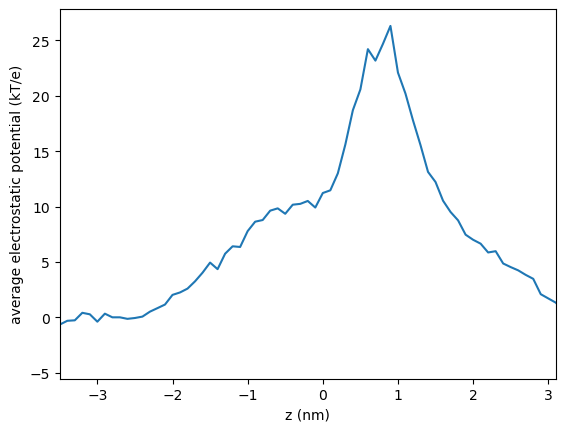

In [34]:
bulk_avg = (np.mean(c_bulk)+np.mean(m_bulk))/2

plt.plot(list(bins) + [4], [np.mean(b)-bulk_avg for b in potentials_by_bin])
plt.xlabel("z (nm)")
plt.ylabel("average electrostatic potential (kT/e)")

end1 = bins[np.argsort([len(b) for b in potentials_by_bin])[-1]]
end2 = bins[0:int(len(bins)/2)][np.argsort([len(b) for b in potentials_by_bin[0:int(len(bins)/2)]])[-1]]
# print(end1, end2)
plt.xlim(end2, end1)

plt.show()

# plt.plot(list(bins) + [4], [len(b) for b in potentials_by_bin])
# plt.show()

# plt.plot(list(bins) + [4], [np.std(b) for b in potentials_by_bin])
# plt.show()

#overlay an AA z distribution on this plot

856
856
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850


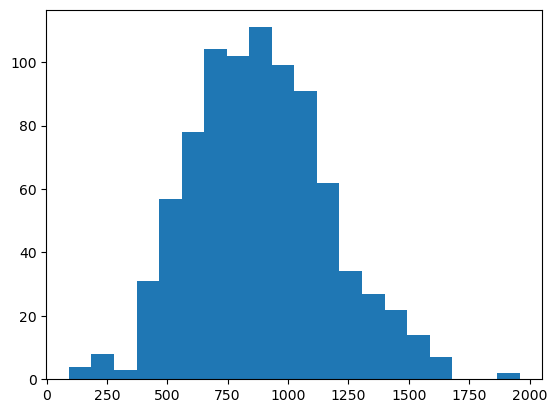

13
35
0
1
645


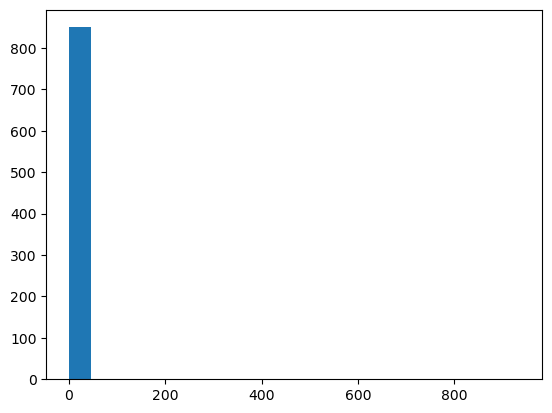

In [ ]:
#load matching dx and npy files and look at the potential values from the dx files at the coordinates in the npy files

#dx files (move into loop later)
dxpath = "/home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/electric_potential/test_aac1/"
dxfiles = [f for f in os.listdir(dxpath) if f[0:9] == "potential"]
#put files in order
dxfiles_sorted = sorted(dxfiles, key=lambda x: int(x.split("-")[3].split(".")[0]))

# dxfile_indices = [int(f.split("-")[3].split(".")[0]) for f in dxfiles]
#print(dxfile_indices)
print(len(dxfiles_sorted))
#print(dxfiles)

xyzpath = "/home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/water_wires_2"

proteins = ["aac1"]
servers = ["wynton", "degrabo"]

for server in servers:
    for protein in proteins:
        for run in range(1,5):
            if server == "degrabo" and run > 2:
                continue


            #xyz.npy files
            runstr = f"run{str(run).zfill(2)}"
            xyzpath_local = "/".join([xyzpath, server, protein, runstr])
            xyzfiles = os.listdir(xyzpath_local)

            xyzpaths = []
            for seg in range(20):

                segstr = f"seg{str(seg).zfill(2)}"
                fnq = f"{protein}-{server}-{runstr}-{segstr}"

                #find all the xyz files for water wires in the current segment in order and then take every 10th one to match what the frame extraction script which was fed into VMD did
                xyzpaths += [f"{xyzpath_local}/{fnq}-frameind{frame}-xyz.npy" for frame in range(15000) if os.path.exists(f"{xyzpath_local}/{fnq}-frameind{frame}-xyz.npy")][::10]


                #for frame in range(15000):

                    # filepath = f"{xyzpath_local}/{fnq}-frameind{frame}-xyz.npy"
                    # if os.path.exists(filepath):
                    #     if x % 10 == 0:
                    #         x+=1

                    #xyzfiles = [f for f in xyzfiles if (f[-8:] == "-xyz.npy" and int(f.split("-")[3][3:]) == 2)]


                # #print(len(xyzfiles))
                # xyzfiles_s10 = [f for f in xyzfiles if ((int(f.split("-")[4][8:])+1) % 10 == 0)] # and int(f.split("-")[3][3:]) == 2)]
                # print(len(xyzfiles_s10))
                # print(sorted(xyzfiles_s10))

            rate_base = 1196.89 #s^-1 #really this has about 1-2 significant figures
            membrane_potential = -160 #meV
            kT = 25.7 #meV at T=298 K
            h = 1/2 #potential fraction at the transition state


            #combine to get potentials along wire
            print(len(xyzpaths))
            if len(xyzpaths) > 0 and len(xyzpaths) == len(dxfiles_sorted):

                avg_c_bulk = []
                avg_m_bulk = []

                max_potentials = []
                rates = []
                xx = 0
                for fxyz, fdx in zip(xyzpaths, dxfiles_sorted):
                    #print(dxpath + fdx)
                    g1 = gd.Grid(dxpath + fdx)
                    xyz = np.load(fxyz)

                    wire_potentials = [g1.grid[int(round(c[0]*(96/9.2)+48)), int(round(c[1]*(96/9.2)+48)), int(round(c[2]*(96/9.2)+44))] for c in xyz]

                    # plt.plot(xyz[:,2], wire_potentials)
                    # plt.show()

                    max_potentials.append(np.max(wire_potentials)-(wire_potentials[0]+wire_potentials[-1])/2)
                    rates.append(rate_base*np.exp(-(max_potentials[-1] + h*membrane_potential/kT)/2)) # conveniently the potentials are in kT/e

                    vs = 50

                    plot_by_slice = False
                    if plot_by_slice:
                        for i in range(0,88,10):
                            plt.imshow(g1.grid[:, :, i].transpose(), vmax = vs, vmin = -vs)
                            plt.title(f'z slice at index {i}')
                            plt.colorbar(label='Electric Potential (kT/e)')

                            for c in xyz:
                                if c[2]*(96/9.2)+44 >= i-5 and c[2]*(96/9.2)+44 < i+5:
                                    plt.scatter([c[0]*(96/9.2)+48], [c[1]*(96/9.2)+48], color = "red") 

                        #plt.plot(xyz[:,1]*(96/9.2)+48, xyz[:,2]*(96/9.2)+48, color="red")


                        plt.show()


                    if xx % 10 == 0:
                        print(xx)

                    xx += 1

                    if False:
                        plt.imshow(g1.grid[48,:,:].transpose(), vmax = vs, vmin = -vs, origin = "lower")
                        plt.colorbar(label='Electric Potential (kT/e)')
                        plt.plot(xyz[:,1]*(96/9.2)+48, xyz[:,2]*(96/9.2)+44, color="red")
                        plt.xlim(0,96)
                        plt.ylim(0,96)
                        plt.show()

                        plt.imshow(g1.grid[:,48,:].transpose(), vmax = vs, vmin = -vs, origin = "lower")
                        plt.colorbar(label='Electric Potential (kT/e)')
                        plt.plot(xyz[:,0]*(96/9.2)+48, xyz[:,2]*(96/9.2)+44, color="red")
                        plt.xlim(0,96)
                        plt.ylim(0,96)                    
                        plt.show()

                        plt.imshow(g1.grid[:,:,60].transpose(), vmax = vs, vmin = -vs, origin = "lower")
                        plt.colorbar(label='Electric Potential (kT/e)')
                        plt.plot(xyz[:,0]*(96/9.2)+48, xyz[:,1]*(96/9.2)+48, color="red")
                        plt.xlim(0,96)
                        plt.ylim(0,96)                    
                        plt.show()

                        sys.exit(0)

                plt.hist([m*kT for m in max_potentials], bins = 20)
                plt.show()
                plt.hist(rates, bins = 20)


            #     print(sorted(xyzfiles))
            #     print(sorted(dxfiles)) #this does not work

            #     #for fxyz, fdx in zip(xyzfiles, dxfiles):

            #     xyz = np.load(f"{xyzpath_local}/{xyzfiles_s10[0]}")

            #     print(xyz.shape)
            #     plt.plot(xyz[:,1], xyz[:,2])



887.118204701035


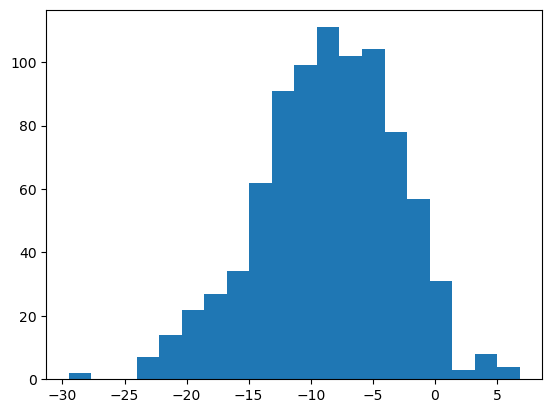

In [ ]:
plt.hist([np.log(r) for r in rates], bins = 20)
np.mean(rates)
#print(np.mean([m*kT for m in max_potentials]))

0.5


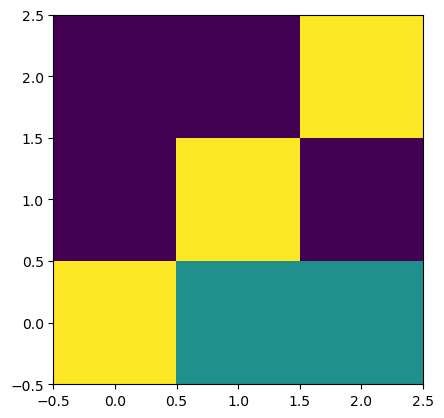

In [ ]:
a = np.array([[1,0,0],[0.5,1,0],[0.5,0,1]])
plt.imshow(a.transpose(), origin='lower')
#print(a[2,0])

(384, 384, 360)


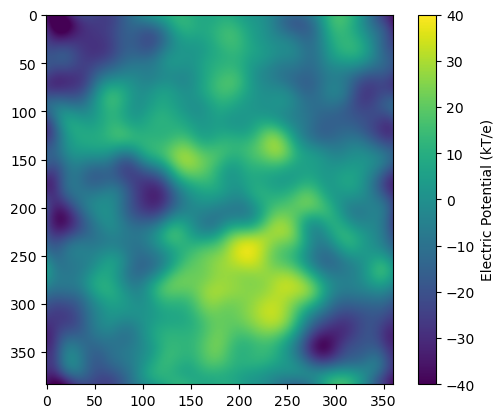

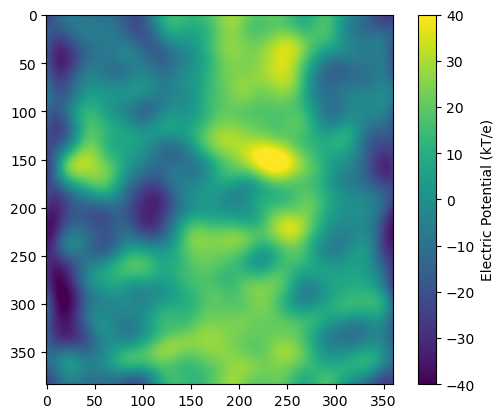

------------------------------------------------------------------------


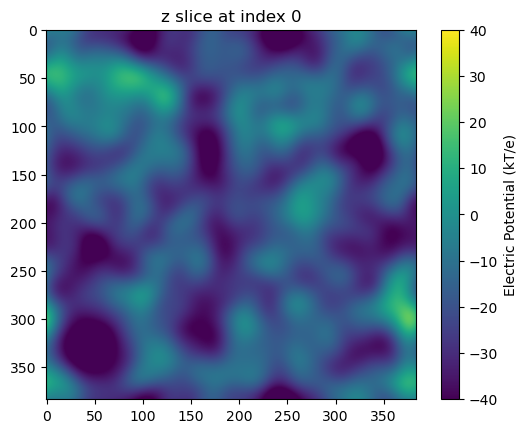

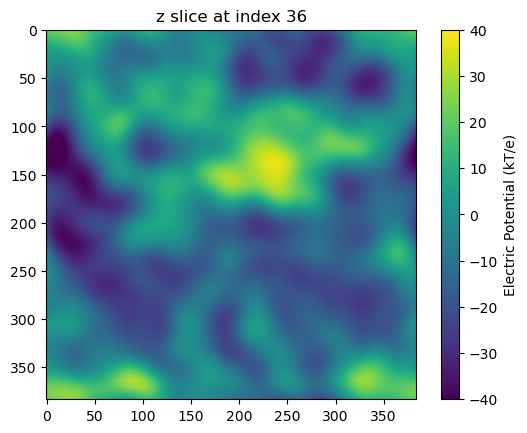

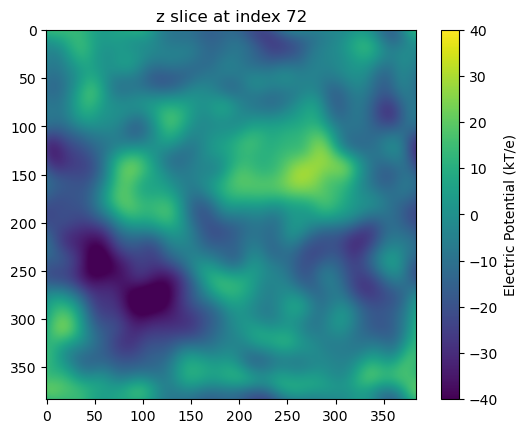

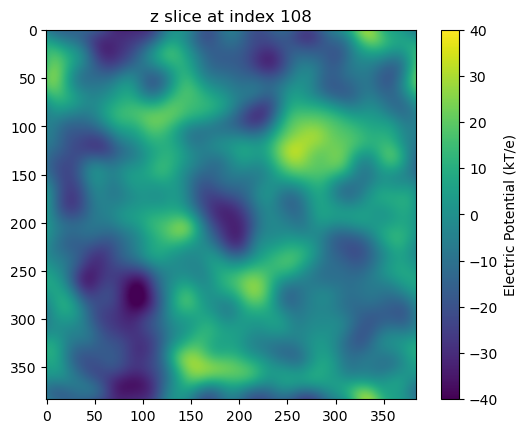

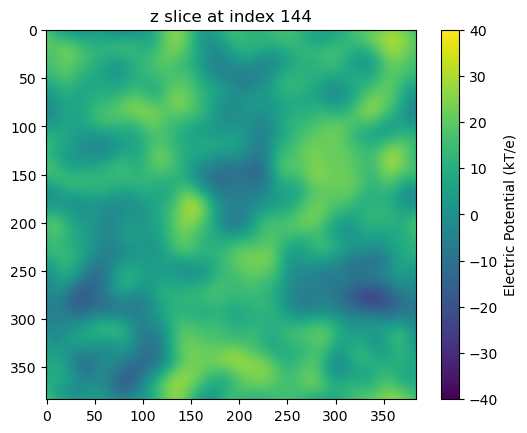

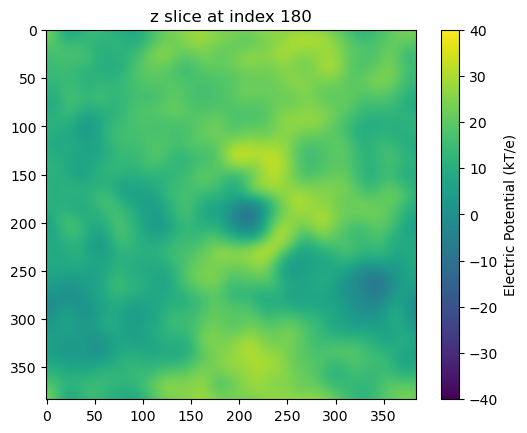

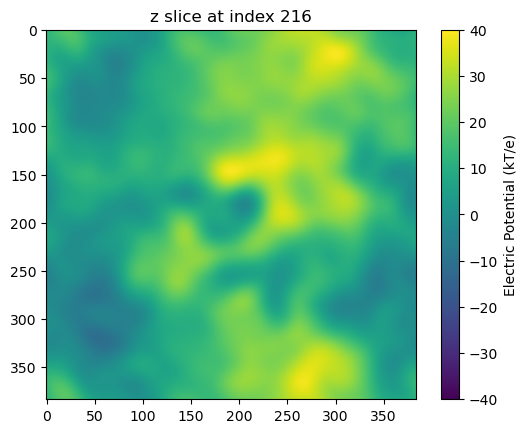

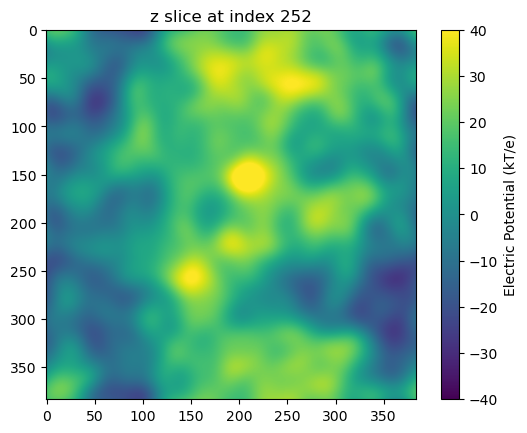

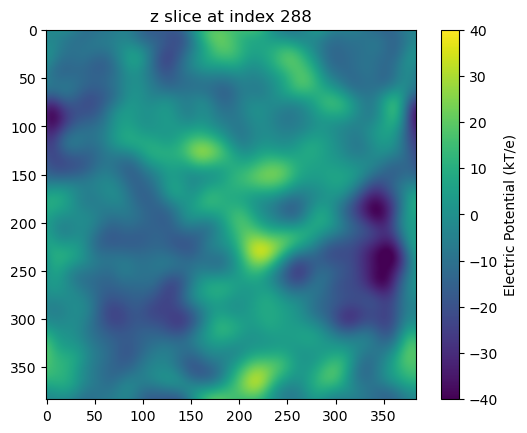

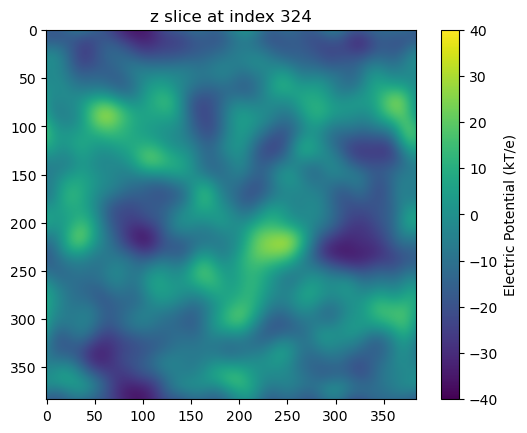

In [7]:
g1 = gd.Grid(f"/home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/electric_potential/high_bin_density_aac1_run1/potential-wireframe-s10-g120-120-110-0.dx")
    #'/home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/electric_potential/test_aac1/potential-wireframe-s10-1.dx')
    #'/home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/electric_potential/test_aac1/test-777.dx')

print(g1.grid.shape)

vs = 40

plt.imshow(g1.grid[192,:,:], vmax = vs, vmin = -vs)
plt.colorbar(label='Electric Potential (kT/e)')
plt.show()

plt.imshow(g1.grid[:,192,:], vmax = vs, vmin = -vs)
plt.colorbar(label='Electric Potential (kT/e)')
plt.show()

print("------------------------------------------------------------------------")

for i in range(0,360,36):
    plt.imshow(g1.grid[:, :, i], vmax = vs, vmin = -vs)
    plt.title(f'z slice at index {i}')
    plt.colorbar(label='Electric Potential (kT/e)')
    plt.show()



In [88]:
g1 = gd.Grid('/home/jonathan/Documents/grabelab/aac1-ucp1/paper-01/electric_potential/vmd1/pmepot_aran_4_pqr.dx') #pmepot_aran_4_pqr



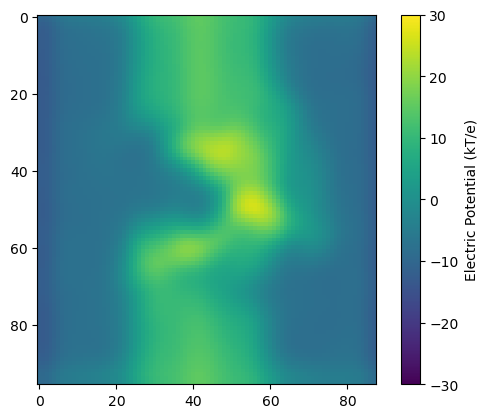

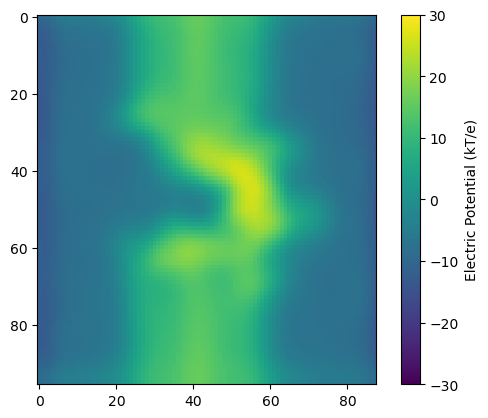

In [ ]:
vs = 30

plt.imshow(g1.grid[48,:,:], vmax = vs, vmin = -vs)
plt.colorbar(label='Electric Potential (kT/e)')
plt.show()

plt.imshow(g1.grid[:,48,:], vmax = vs, vmin = -vs)
plt.colorbar(label='Electric Potential (kT/e)')
plt.show()

#try 0.25A spacing


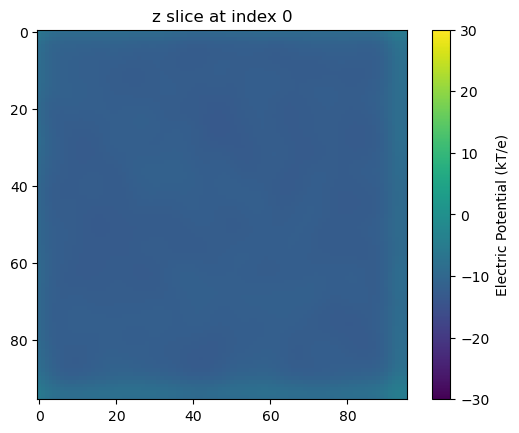

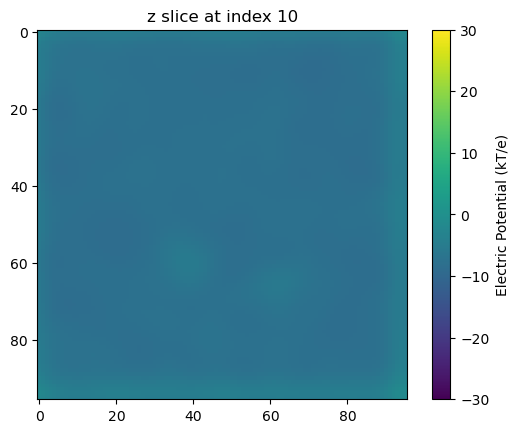

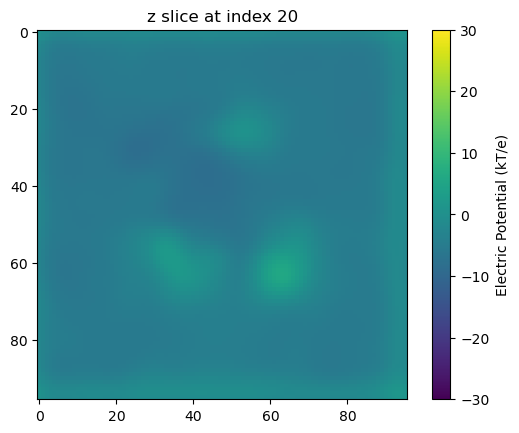

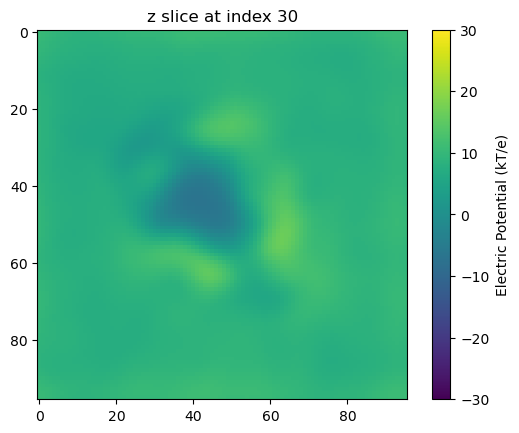

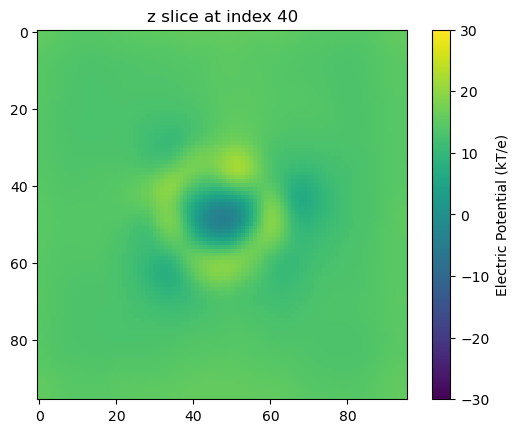

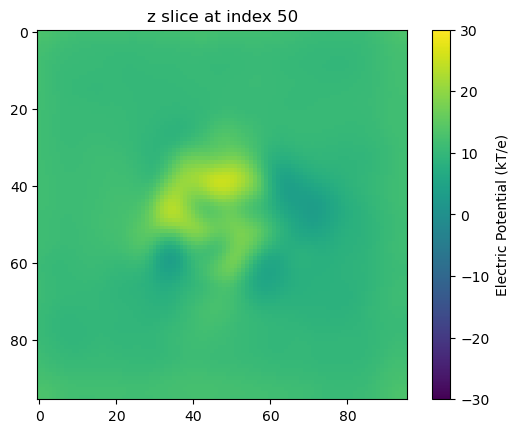

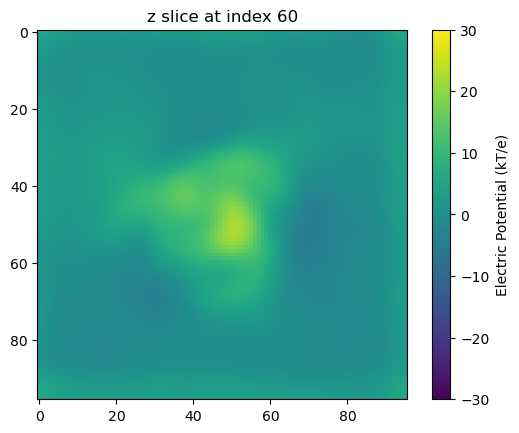

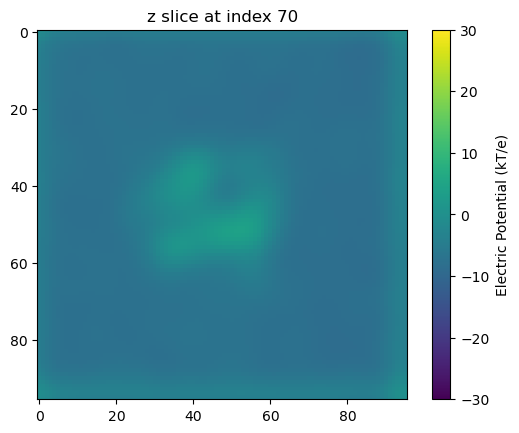

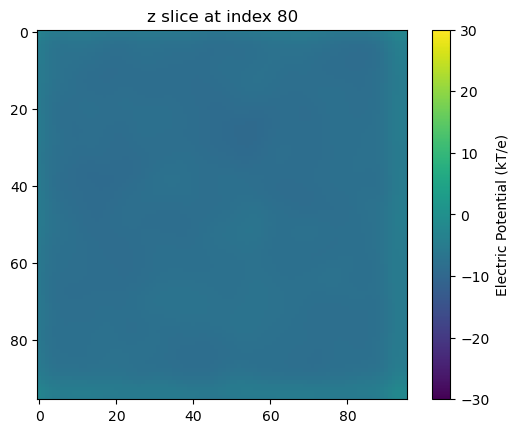

In [92]:
for i in range(0,88,10):
    plt.imshow(g1.grid[:, :, i], vmax = vs, vmin = -vs)
    plt.title(f'z slice at index {i}')
    plt.colorbar(label='Electric Potential (kT/e)')
    plt.show()

In [ ]:
#/home/jonathan/Documents/grabelab/aac1-ucp1/paper-01/electric_potential/vmd1
g = gd.Grid('/home/jonathan/pmepot1.dx')

In [11]:
g.grid.shape

(96, 96, 96)

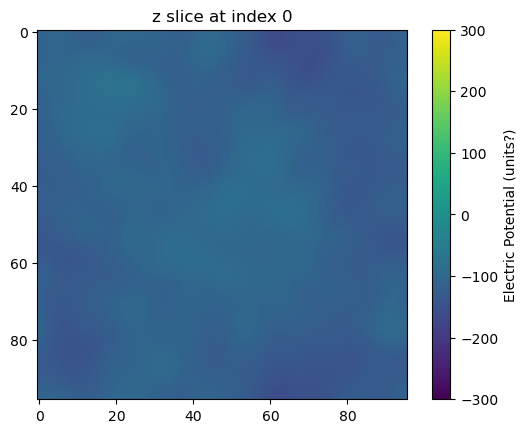

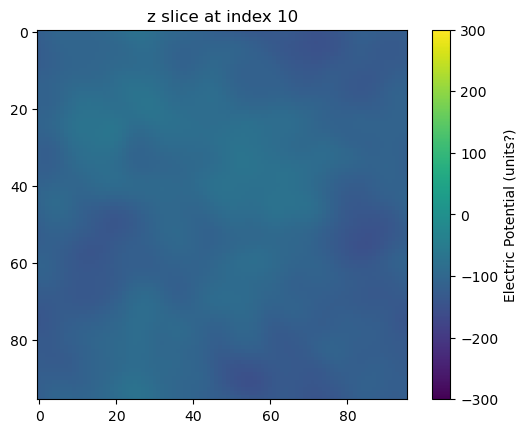

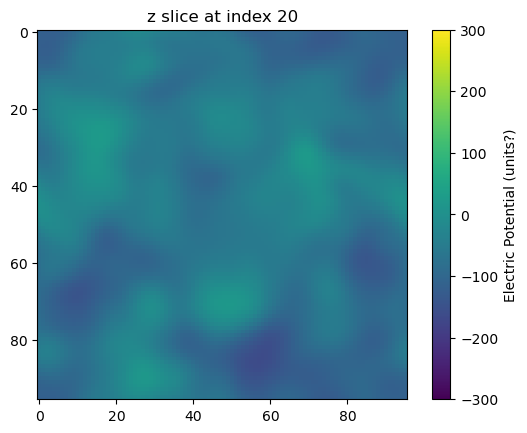

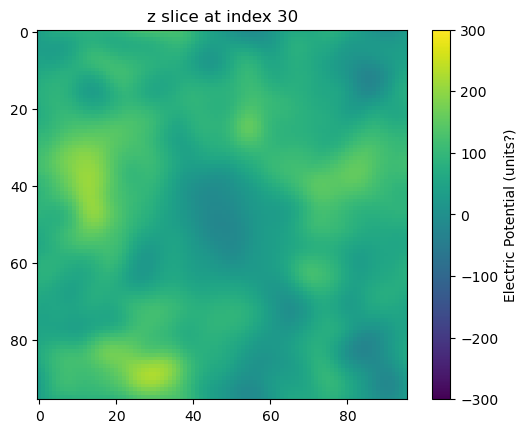

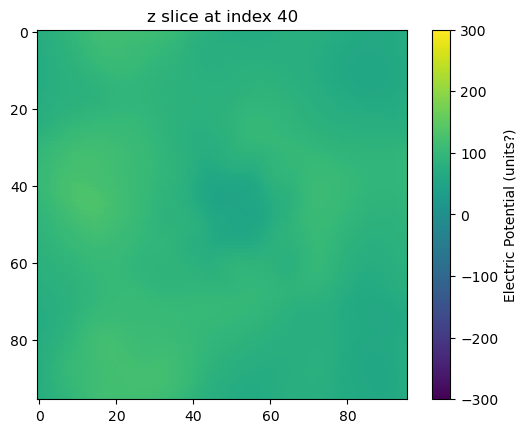

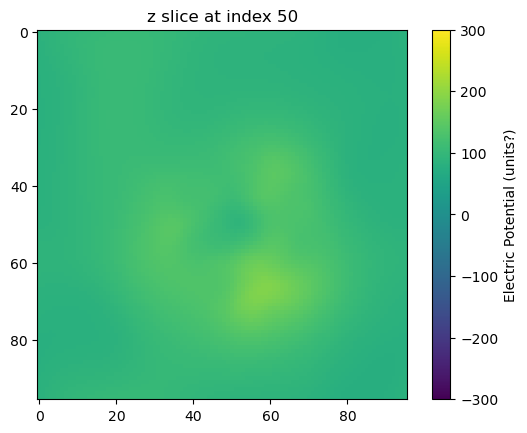

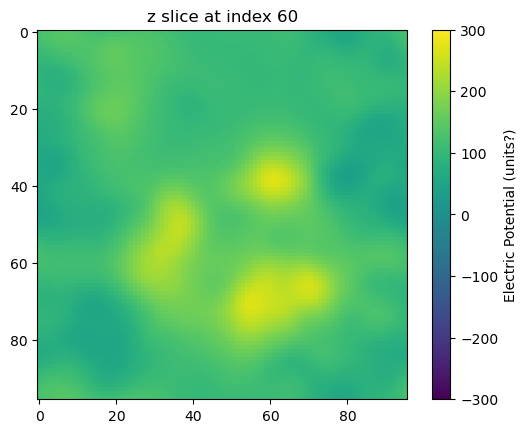

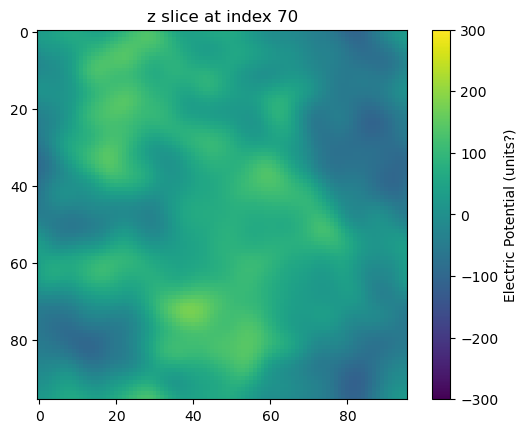

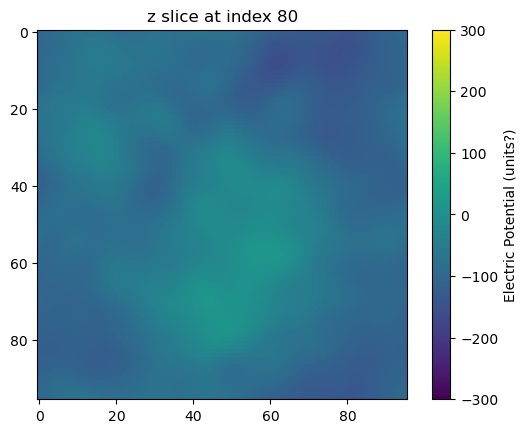

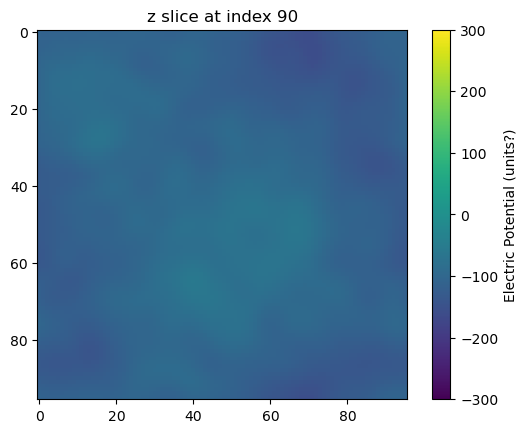

In [32]:
# plt.imshow(g.grid[48,:,:])
# plt.show()
# plt.imshow(g.grid[:,48,:])
# plt.show()

g1 = gd.Grid('/home/jonathan/pmepot_aran.dx')

vs = 300
for i in range(0,96,10):
    plt.imshow(g1.grid[:, :, i], vmax = vs, vmin = -vs)
    plt.title(f'z slice at index {i}')
    plt.colorbar(label='Electric Potential (units?)')
    plt.show()

# plt.imshow(g.grid[:,:,90])
# plt.show()

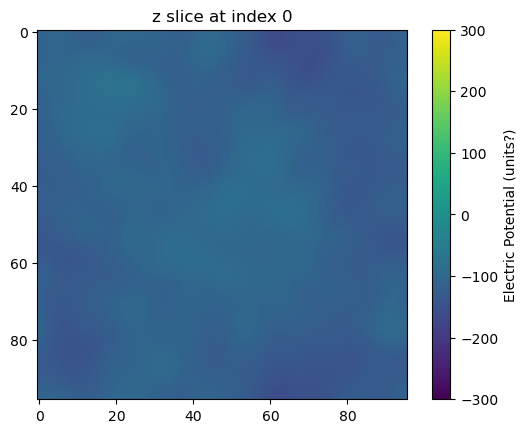

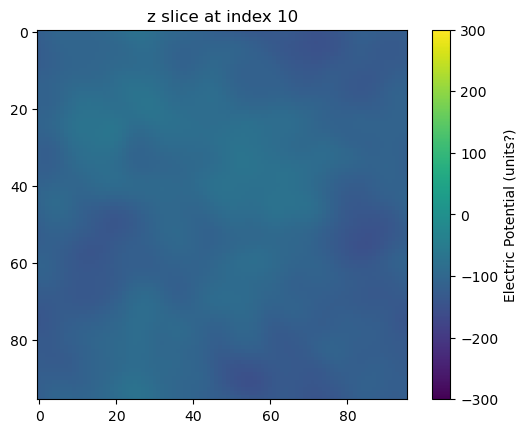

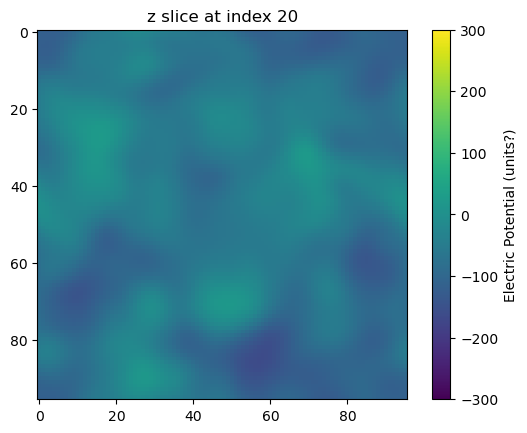

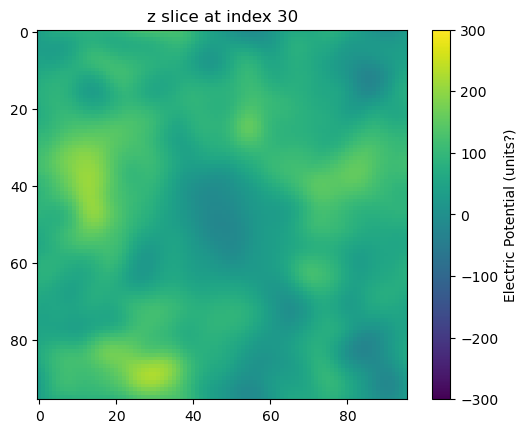

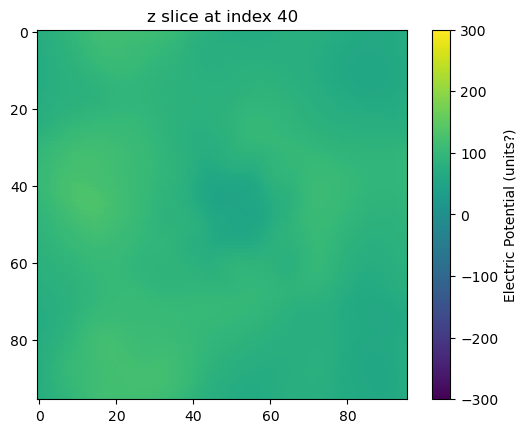

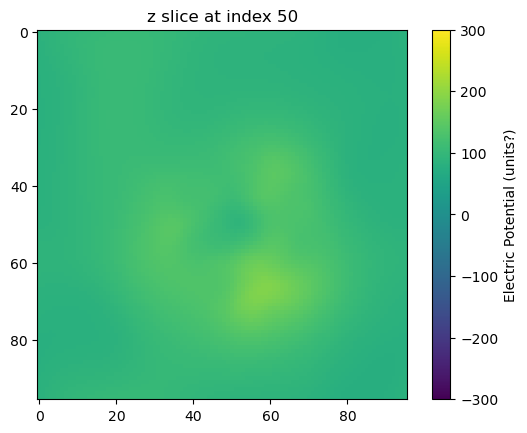

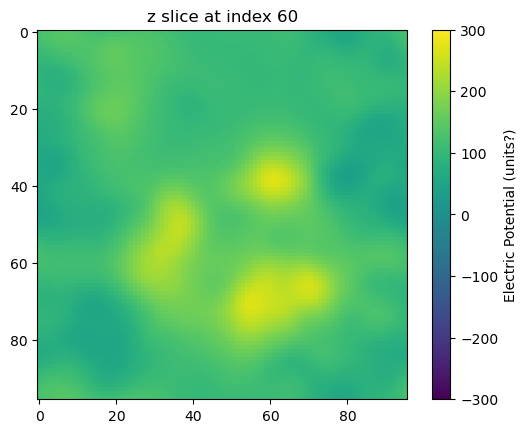

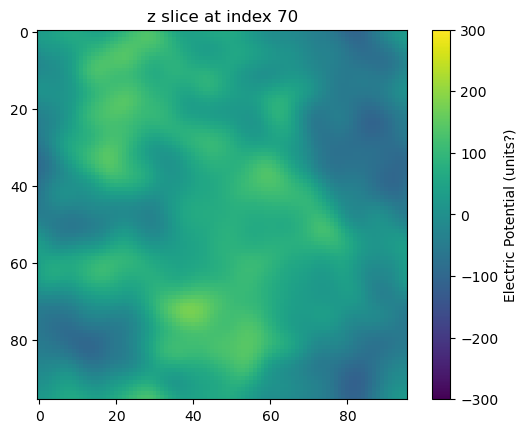

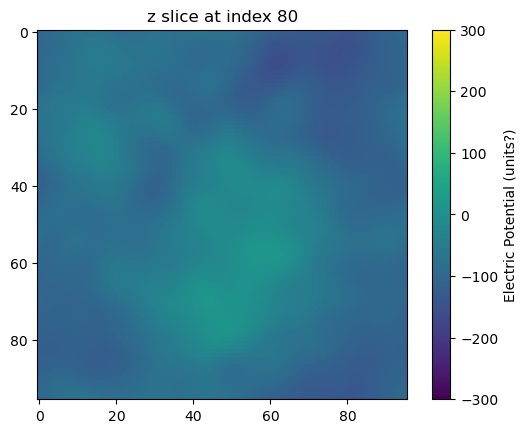

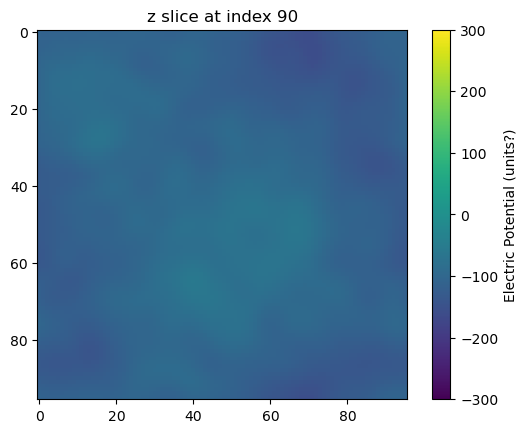

In [33]:
g2 = gd.Grid('/home/jonathan/pmepot_noaran.dx')

vs = 300
for i in range(0,96,10):
    plt.imshow(g.grid[:, :, i], vmax = vs, vmin = -vs)
    plt.title(f'z slice at index {i}')
    plt.colorbar(label='Electric Potential (units?)')
    plt.show()

0.0


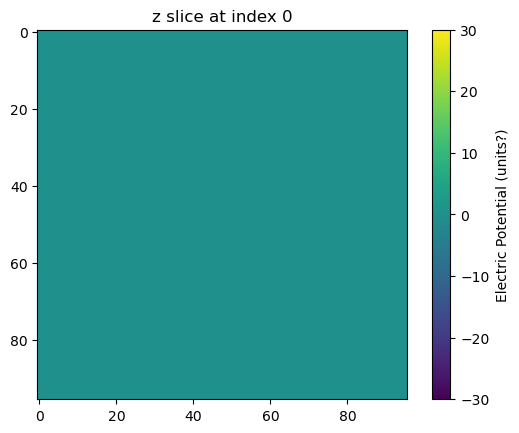

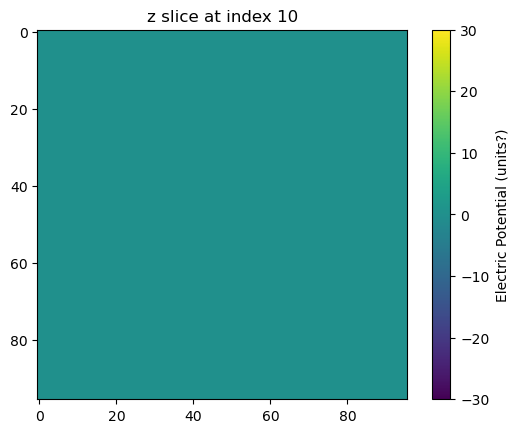

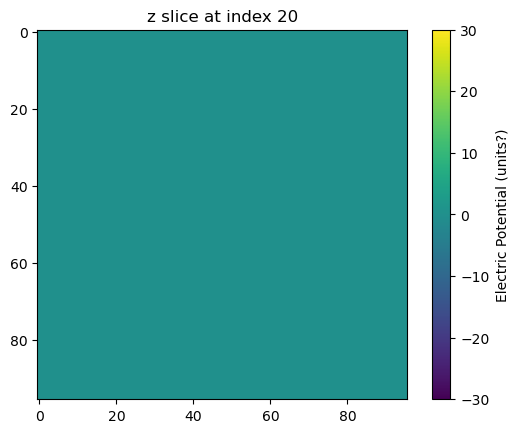

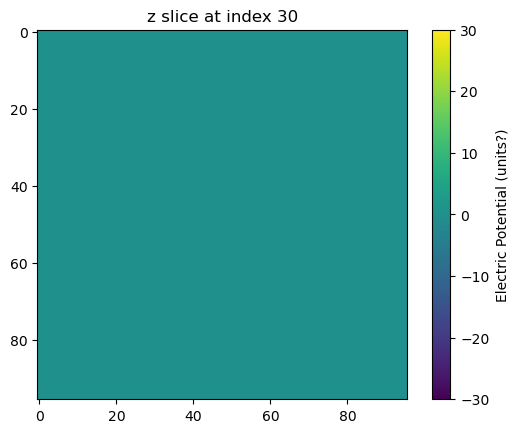

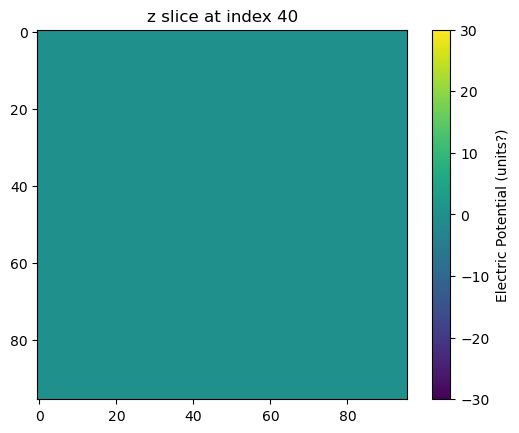

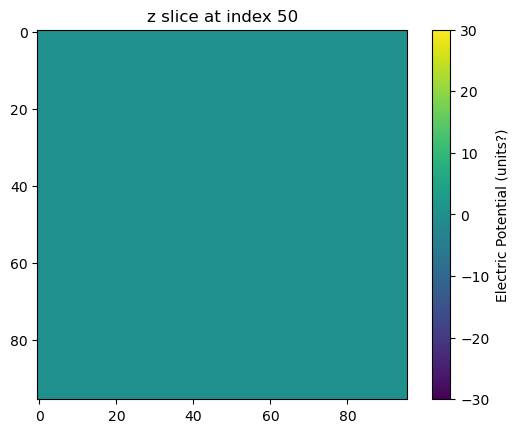

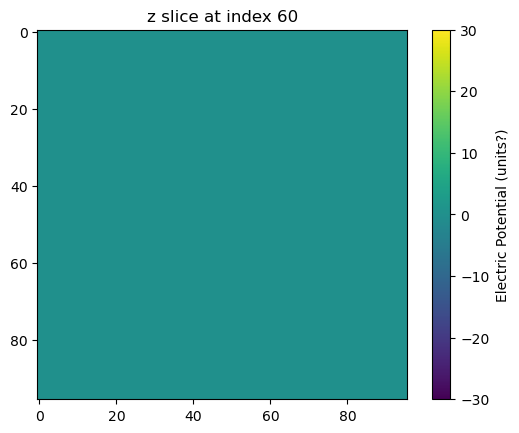

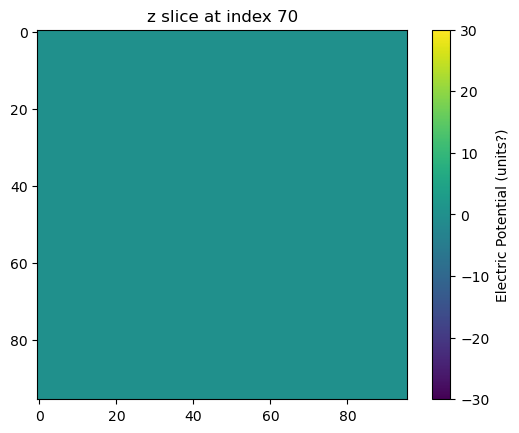

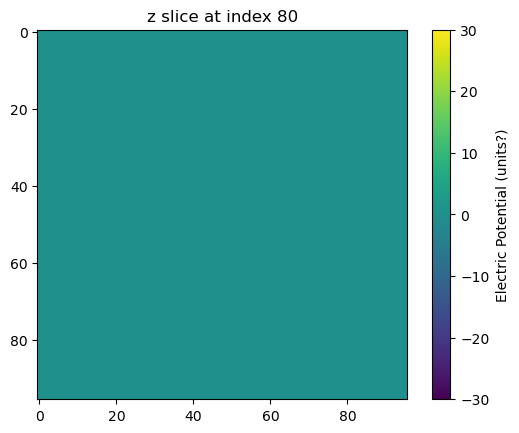

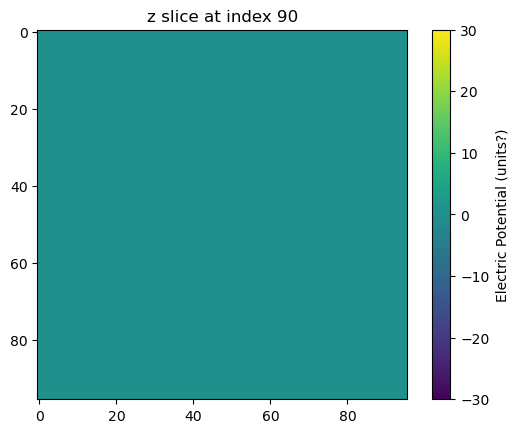

In [35]:
dg = g1-g2
print(np.sum(abs(dg.grid)))

vs = 30
for i in range(0,96,10):
    plt.imshow(dg.grid[:, :, i], vmax = vs, vmin = -vs)
    plt.title(f'z slice at index {i}')
    plt.colorbar(label='Electric Potential (units?)')
    plt.show()

0.0